<a href="https://colab.research.google.com/github/Maks6666/ML/blob/main/pytorch_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [136]:
import pandas as pd

Дані про діабет

In [137]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/Healthcare-Diabetes.csv',
                 index_col='Id')

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [138]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.000000,0.416873,0.234415,0.483333,1
2,0.058824,0.427136,0.540984,0.263636,0.000000,0.330025,0.116567,0.166667,0
3,0.470588,0.919598,0.524590,0.000000,0.000000,0.289082,0.253629,0.183333,1
4,0.058824,0.447236,0.540984,0.209091,0.111111,0.348635,0.038002,0.000000,0
5,0.000000,0.688442,0.327869,0.318182,0.198582,0.534739,0.943638,0.200000,1


Потрібно на основі інформації пацієнта виявити наявність діабету `Outcome`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [139]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X.values)
    self.y = torch.FloatTensor(y.values)
    self.y = self.y.reshape(-1, 1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [140]:
from sklearn.model_selection import train_test_split

X = df.drop("Outcome", axis='columns')
y = df["Outcome"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [141]:
train_ds = MyDataset(x_train, y_train)

In [142]:
test_ds = MyDataset(x_test, y_test)

# Завдання 2
Створіть DataLoader

In [143]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle=True)

test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle=True)

# Завдання 3
Створіть нейромережу

In [144]:
from torch import nn
import torch.nn.functional as F
import numpy as np

class BinaryClassifier(nn.Module):
  def __init__(self, input_layer, hidden_layer, output_layer):
    super().__init__()

    self.linear_1 = nn.Linear(input_layer, hidden_layer)
    self.linear_2 = nn.Linear(hidden_layer, hidden_layer//2)
    self.linear_3 = nn.Linear(hidden_layer//2, hidden_layer//4)
    self.linear_4 = nn.Linear(hidden_layer//4, hidden_layer//8)
    self.linear_5 = nn.Linear(hidden_layer//8, output_layer)

  def forward(self, x):
    out = self.linear_1(x)
    out = F.relu(out)

    out = self.linear_2(out)
    out = F.relu(out)

    out = self.linear_3(out)
    out = F.relu(out)

    out = self.linear_4(out)
    out = F.relu(out)

    out = self.linear_5(out)
    out = F.sigmoid(out)
    return out


  def predict(self, X, device='cpu'):
      X = torch.FloatTensor(np.array(X)).to(device)

      with torch.no_grad():
        y_pred = self.forward(X)

      return y_pred.cpu().numpy()


model = BinaryClassifier(8, 40, 1)
model




BinaryClassifier(
  (linear_1): Linear(in_features=8, out_features=40, bias=True)
  (linear_2): Linear(in_features=40, out_features=20, bias=True)
  (linear_3): Linear(in_features=20, out_features=10, bias=True)
  (linear_4): Linear(in_features=10, out_features=5, bias=True)
  (linear_5): Linear(in_features=5, out_features=1, bias=True)
)

In [145]:
from torchsummary import summary

summary(model, input_size=(8, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]             360
            Linear-2                   [-1, 20]             820
            Linear-3                   [-1, 10]             210
            Linear-4                    [-1, 5]              55
            Linear-5                    [-1, 1]               6
Total params: 1,451
Trainable params: 1,451
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [146]:
from torch.optim import Adam
loss_func = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-2)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [147]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=70, device='cpu', task='regression'):


    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dataloader:
            x  = batch[0].to(device)
            y  = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [148]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_func, train_dataloader, test_dataloader,
                epochs=70,
                metrics=[accuracy_score, roc_auc_score],
                device="cpu",
                task='binary')

train() called: model=BinaryClassifier, opt=Adam(lr=0.010000), epochs=70, device=cpu

Epoch    1    0sec	loss:      0.596	val_loss:      0.506	accuracy_score:       0.67	val_accuracy_score:      0.733	roc_auc_score:      0.765	val_roc_auc_score:      0.801	
Epoch    2    0sec	loss:      0.509	val_loss:       0.48	accuracy_score:      0.738	val_accuracy_score:      0.771	roc_auc_score:      0.817	val_roc_auc_score:      0.831	
Epoch    3    0sec	loss:      0.491	val_loss:      0.488	accuracy_score:      0.762	val_accuracy_score:      0.745	roc_auc_score:      0.844	val_roc_auc_score:      0.836	
Epoch    4    0sec	loss:      0.474	val_loss:      0.463	accuracy_score:      0.771	val_accuracy_score:      0.762	roc_auc_score:      0.849	val_roc_auc_score:      0.836	
Epoch    5    0sec	loss:      0.463	val_loss:      0.471	accuracy_score:      0.781	val_accuracy_score:      0.751	roc_auc_score:      0.854	val_roc_auc_score:      0.838	
Epoch    6    0sec	loss:      0.443	val_loss:      0.4

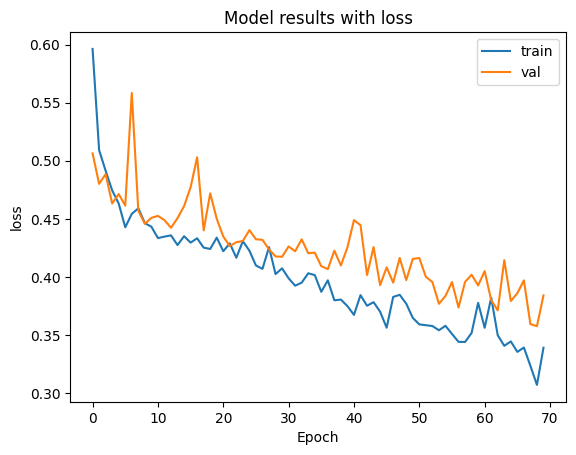

In [149]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

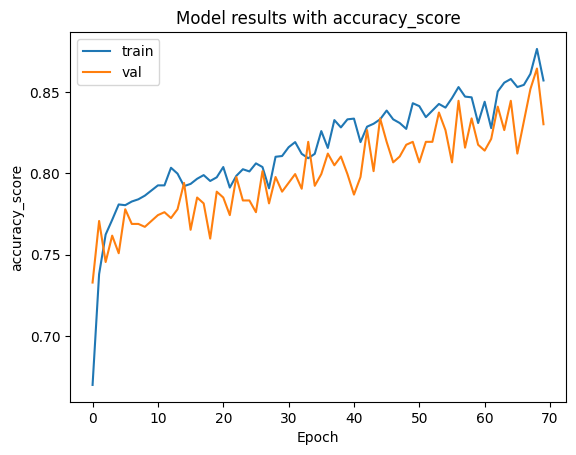

In [150]:
plot_metric(history, 'accuracy_score')


In [151]:
x_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Id,,,,,,,,
1379,0.176471,0.532663,0.442623,0.190909,0.186761,0.383375,0.091375,0.050000
840,0.294118,0.698492,0.524590,0.318182,0.165485,0.354839,0.142186,0.083333
2165,0.529412,0.824121,0.688525,0.190909,0.000000,0.382134,0.321520,0.183333
2620,0.588235,0.507538,0.622951,0.436364,0.212766,0.408189,0.039710,0.700000
928,1.000000,0.819095,0.590164,0.372727,0.134752,0.507444,0.315542,0.433333
...,...,...,...,...,...,...,...,...
875,0.058824,0.482412,1.000000,0.000000,0.000000,0.277916,0.055081,0.100000
2032,0.058824,0.633166,0.459016,0.263636,0.179669,0.356079,0.308711,0.000000
101,0.058824,0.819095,0.590164,0.000000,0.000000,0.483871,0.488471,0.200000


[]

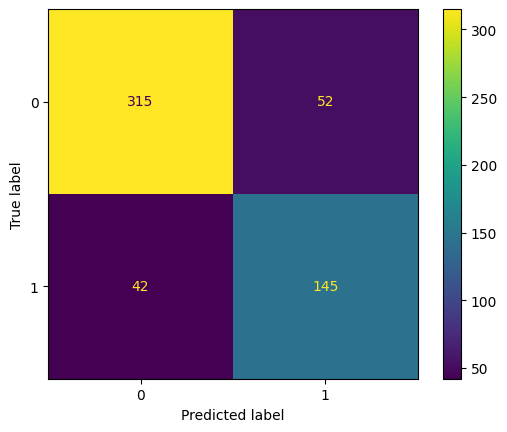

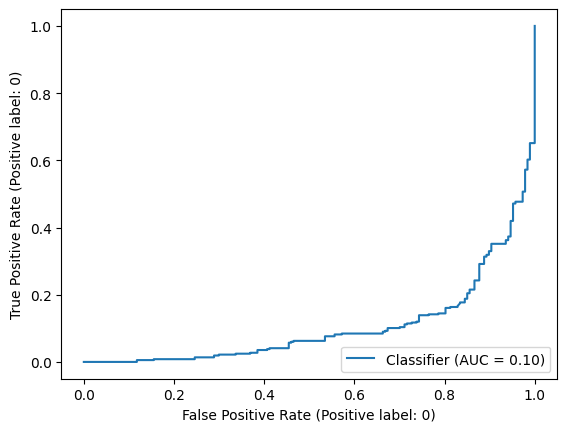

In [152]:

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to("cpu")
y_pred = model.predict(x_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=0)
plt.plot()


# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [153]:
torch.save(model, "model.pt")

In [154]:
loaded_model = torch.load("/content/model.pt")

In [155]:
X_data = torch.FloatTensor(x_test.iloc[:1].values)
X_data = X_data.to("cpu")

In [156]:
res = float(loaded_model.predict(X_data))
res

<ipython-input-156-7926f663478f>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = float(loaded_model.predict(X_data))


0.020595623180270195

In [157]:
real_res = y_test.iloc[:1]

loss = res - real_res
loss

Id
1379    0.020596
Name: Outcome, dtype: float64